In [3]:
! pip install transformers datasets sacrebleu rouge_score  py7zr accelerate>=0.20.1 sentencepiece==0.1.99

In [4]:
from datasets import load_dataset
dataset = load_dataset("cnn_dailymail" , version="3.0.0" )
print(f"Features: {dataset['train'].column_names}" )

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Features: ['article', 'highlights', 'id']


In [5]:
sample = dataset["train" ][1]
sample


{'article': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won\'t do what they\'re told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less li

In [6]:
sample_text = dataset["train" ][1]["article" ][: 2000]
# We'll collect the generated summaries of each model in a dictionary
summaries = {}
print(sample_text)

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to follow dir

In [7]:
import nltk
from nltk.tokenize import sent_tokenize
nltk. download("punkt" )
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['The U.S. are a country.', 'The U.N. is an organization.']

### Baseline

In [8]:
def three_sentence_summary(text):
 return " \n" . join(sent_tokenize(text)[: 3])

summaries["baseline" ] = three_sentence_summary(sample_text)


### GPT-2

In [9]:
from transformers import pipeline, set_seed
# we will add seed to generate the get the same result every time we run this code
set_seed(42)
# we will pass text generation as task name argument and select the large version of gpt2 to the model argument
pipe = pipeline("text-generation" , model="gpt2" )
# then we add the TL DR experssion at the end of input text
gpt2_query = sample_text + " \nTL;DR: \n"
# then we will pass the query to the model and specify maximum length to 512 and set clean up tokenization spaces to remove
# any extra spaces introduced during the tokenization process
# This can be useful to ensure that the output text appears clean and well-formatted without unnecessary spacing issues.
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
# then we use sentence tokenize from NLTK to add newline to separate summary sentences
summaries["gpt2" ] = " \n" . join(sent_tokenize(pipe_out[0]["generated_text" ][len(gpt2_query) :]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [10]:
summaries["gpt2" ]

"1. \nThis jail has not provided mental health services for more than 10 years. \n2. \nIt was in a state or county jail after it opened in 2002 that 1 year's worth of physical therapy was provided from the prison community, according to the Miami-Dade County Corrections Commission. \nAccording to a report by the ACLU,  \xa0 about 60 prisoners were on trial for"

### T5

In [11]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


### BART

In [12]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

### PEGASUS

In [13]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .", ".\n")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Comparing  Summaries

In [14]:
reference = dataset["train"][1]["highlights"]
print("GROUND TRUTH")
print(reference)
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")


GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. 
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. 
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2
1. 
This jail has not provided mental health services for more than 10 years. 
2. 
It was in a state or county jail after it opened in 2002 that 1 year's worth of physical therapy was provided from the prison communi

### Evaluation Metrics of Generated Text

#### BLEU

In [15]:
# ! pip install transformers datasets sacrebleu
from datasets import load_metric
bleu_metric = load_metric("sacrebleu" )

<ipython-input-15-570d8af83853>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu" )


In [16]:
import pandas as pd
import numpy as np

bleu_metric.add( prediction="the the the the the the" ,
                 reference=["the cat is on the mat" ])

results = bleu_metric.compute(smooth_method="floor" , smooth_value=0)

results["precisions" ] = [np. round(p, 2) for p in results["precisions" ]]

pd.DataFrame.from_dict(results, orient="index" , columns=["Value" ])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [17]:
bleu_metric.add(prediction="the cat is on mat" ,
                reference=["the cat is on the mat" ])

results = bleu_metric. compute(smooth_method="floor" , smooth_value=0)
results["precisions" ] = [np. round(p, 2) for p in results["precisions" ]]
pd. DataFrame. from_dict(results, orient="index" , columns=["Value" ])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


In [18]:
from datasets import load_metric
rouge_metric = load_metric("rouge" )

In [19]:
#reference = dataset["train" ][1]["highlights" ]
import pandas as pd

records = []
rouge_names = [ "rougeL" , "rougeLsum" ]
for model_name in summaries:
 rouge_metric.add(prediction=summaries[model_name], reference=reference)
 score = rouge_metric.compute()

# results -->    'rougeL' : AggregateScore(    low=Score(precision=0.13253012048192772, recall=0.3793103448275862, fmeasure=0.19642857142857145),
#                                  mid=Score(precision=0.13253012048192772, recall=0.3793103448275862, fmeasure=0.19642857142857145),
#                                  high=Score(precision=0.13253012048192772, recall=0.3793103448275862, fmeasure=0.19642857142857145)),
#         -->  'rougeLsum' : AggregateScore( low=Score(precision=0.18072289156626506, recall=0.5172413793103449, fmeasure=0.26785714285714285),
#                                  mid=Score(precision=0.18072289156626506, recall=0.5172413793103449, fmeasure=0.26785714285714285),
#                                  high=Score(precision=0.18072289156626506, recall=0.5172413793103449, fmeasure=0.26785714285714285))}

 rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
 # { 'rougeL': 0.19642857142857145, 'rougeLsum': 0.26785714285714285}
 records.append(rouge_dict)


In [21]:
import pandas as pd
pd.DataFrame.from_records(records, index=summaries. keys())

,rougeL,rougeLsum
baseline,0.206349,0.285714
gpt2,0.123894,0.159292
t5,0.255319,0.382979
bart,0.316832,0.415842
pegasus,0.277228,0.316832


# **Evaluating PEGASUS on the CNN/DailyMail Dataset**

In [22]:
import nltk
from nltk.tokenize import sent_tokenize
nltk. download("punkt" )

def three_sentence_summary(text):
 return " \n" . join(sent_tokenize(text)[: 3])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
def evaluate_summaries_baseline(dataset, metric,column_text="article" , column_summary="highlights" ):
  summaries = [three_sentence_summary(text) for text in dataset[column_text]]
  metric.add_batch(predictions=summaries, references=dataset[column_summary])
  score = metric.compute()
  return score

In [24]:
test_sampled = dataset["test" ].shuffle(seed=42).select(range(1000))

In [25]:
from datasets import load_metric
import pandas as pd

rouge_metric = load_metric("rouge" )
rouge_names = [ "rougeL" , "rougeLsum" ]
score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index" , columns=["baseline" ]).T

,rougeL,rougeLsum
baseline,0.245061,0.354239


In [26]:
from tqdm import tqdm
import torch
# first we will check for gpu avaliablity
device = "cuda" if torch. cuda. is_available() else "cpu"

# then we create an small function that made chunks from our dataset samples
# by splitting the dataset into smaller batches that we can process simultaneously
def chunks(list_of_elements, batch_size):
  for i in range(0, len(list_of_elements), batch_size):
      yield list_of_elements[i : i + batch_size]

# now we will create the main function to evaluate pegasus model , the evaluate pegausu function will take these arguments,
# the dataset , the used metric , the transformer model , the tokenizer , the batch size , the used device whether gpu or cpu ,
# the text column , and the summary column
def evaluate_pegasus(dataset,
                      metric,
                      model,
                      tokenizer,
                      batch_size=16,
                      device=device,
                      column_text="article" ,
                      column_summary="highlights" ):
    # then we make a chunks from our test samples
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))
    # then we loop over the batches. tokenized them and pass them to the model to generate the summary using beam
    #  search, the length penalty argument to ensure that the model does not generate sequences that
    # are too long , here we used the same generation parameters as proposed in the PEGASUS paper
    for article_batch, target_batch in tqdm( zip(article_batches, target_batches), total=len(article_batches)):
        inputs = tokenizer( article_batch , max_length=1024,  truncation=True, padding="max_length" , return_tensors="pt" )
        summaries = model.generate(input_ids=inputs["input_ids" ].to(device),
                                attention_mask=inputs["attention_mask" ].to(device),
                                length_penalty=0.8,
                                num_beams=8,
                                max_length=128 )
        # then we decode the output results to get the summarized text
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]
        decoded_summaries = [d. replace("<n>" , " " ) for d in decoded_summaries]
        # then we add the whole batch results with its reference  to the metric to be evaluated
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
    # after iterate through all batches it become ready to be evaluated now with compute method
    score = metric.compute()
    return score





In [27]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer. from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM. from_pretrained(model_ckpt).to(device)

score = evaluate_pegasus(test_sampled, rouge_metric, model, tokenizer, batch_size=8)



Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 125/125 [24:10<00:00, 11.61s/it]


In [ ]:
rouge_names = [ "rougeL" , "rougeLsum" ]
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus" ])

,rougeL,rougeLsum
pegasus,0.312097,0.374039


# **Fine-Tuning PEGASUS**

In [ ]:
from datasets import load_dataset
dataset_samsum = load_dataset("samsum" )
dataset_samsum

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:

print("Dialogue:" )
print(dataset_samsum["test" ][0]["dialogue" ])
print(" \nSummary:" )
print(dataset_samsum["test" ][0]["summary" ])

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye
 
Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [ ]:
from transformers import pipeline
pipe = pipeline("summarization" , model="google/pegasus-cnn_dailymail" )
pipe_out = pipe(dataset_samsum["test" ][0]["dialogue" ])
print("Summary:" )
print(pipe_out[0]["summary_text" ].replace(" .<n>" , ". \n" ))

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together. 
Hannah: I'd rather you texted him. 
Amanda: Just text him .


In [ ]:
from datasets import load_metric
import pandas as pd
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch. cuda. is_available() else "cpu"

rouge_metric = load_metric("rouge" )
rouge_names = [ "rougeL" , "rougeLsum" ]

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

score = evaluate_pegasus(dataset_samsum["test" ],
                                   rouge_metric,
                                   model,
                                   tokenizer,
                                   column_text="dialogue" ,
                                   column_summary="summary" ,
                                   batch_size=8)

rouge_dict = dict((rn, score[rn] .mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus" ])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 103/103 [19:13<00:00, 11.20s/it]


,rougeL,rougeLsum
pegasus,0.229207,0.229283


Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


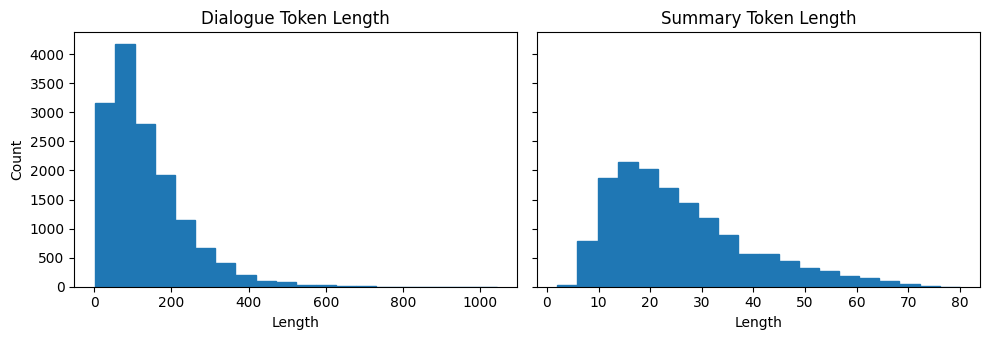

In [ ]:
import matplotlib.pyplot as plt

dialogue_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train" ]["dialogue" ]]
summary_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train" ]["summary" ]]
fig, axes = plt. subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(dialogue_len, bins=20, color="C0" , edgecolor="C0" )
axes[0].set_title("Dialogue Token Length" )
axes[0].set_xlabel("Length" )
axes[0].set_ylabel("Count" )
axes[1].hist(summary_len, bins=20, color="C0" , edgecolor="C0" )
axes[1].set_title("Summary Token Length" )
axes[1].set_xlabel("Length" )
plt.tight_layout()
plt.show()


In [ ]:
! pip install accelerate -U

In [ ]:
def tokenize_samsum_data(example_batch):
    input_encodings = tokenizer( example_batch["dialogue" ],
                                 max_length=1024,
                                 truncation=True)
    with tokenizer.as_target_tokenizer():
      target_encodings = tokenizer(example_batch["summary" ],
                                  max_length=128,
                                  truncation=True)
    return {  "input_ids" : input_encodings["input_ids" ],
            "attention_mask" : input_encodings["attention_mask" ],
            "labels" : target_encodings["input_ids" ]}

In [ ]:
dataset_samsum_tokenizied = dataset_samsum.map(tokenize_samsum_data,batched=True)
columns = ["input_ids" , "labels" , "attention_mask" ]
dataset_samsum_tokenizied.set_format(type="torch" , columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3635: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq,  AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum' ,
    num_train_epochs=1,
    warmup_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='steps' ,
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16 )

In [ ]:
trainer = Trainer( model=model,
                   args=training_args,
                   tokenizer=tokenizer,
                   data_collator=seq2seq_data_collator,
                   train_dataset=dataset_samsum_tokenizied["train" ],
                   eval_dataset=dataset_samsum_tokenizied["validation" ])

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,1.629700,1.485818


TrainOutput(global_step=920, training_loss=1.819335088522538, metrics={'train_runtime': 2870.9984, 'train_samples_per_second': 5.131, 'train_steps_per_second': 0.32, 'total_flos': 5526698901602304.0, 'train_loss': 1.819335088522538, 'epoch': 1.0})

In [ ]:
score = evaluate_pegasus(dataset_samsum["test" ],
                                   rouge_metric,
                                   trainer.model,
                                   tokenizer,
                                   batch_size=2,
                                   column_text="dialogue" ,
                                   column_summary="summary" )

100%|██████████| 410/410 [14:30<00:00,  2.12s/it]


In [ ]:
rouge_dict = dict((rn, score[rn] . mid. fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus" ])

,rougeL,rougeLsum
pegasus,0.340055,0.340025


In [ ]:
model.save_pretrained("/content/pegasus-samsum")
tokenizer.save_pretrained("/content/pegasus-samsum")

('/content/pegasus-samsum/tokenizer_config.json',
 '/content/pegasus-samsum/special_tokens_map.json',
 '/content/pegasus-samsum/spiece.model',
 '/content/pegasus-samsum/added_tokens.json',
 '/content/pegasus-samsum/tokenizer.json')

In [ ]:
from transformers import pipeline
gen_kwargs = {"length_penalty" : 0.8, "num_beams" : 8, "max_length" : 128}
sample_text = dataset_samsum["test" ][0]["dialogue" ]
reference = dataset_samsum["test" ][0]["summary" ]
pipe = pipeline("summarization" , model="/content/pegasus-samsum" )
print("Dialogue:" )
print(sample_text)
print(" \nReference Summary:" )
print(reference)
print(" \nModel Summary:" )
print(pipe(sample_text, **gen_kwargs)[0]["summary_text" ])

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye
 
Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.
 
Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.
